Deep Neural Network with PyTorch course: Week 1

Creating 1D tensor

# Loading an image


In [49]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fir_filter_design as ffd, filtfilt



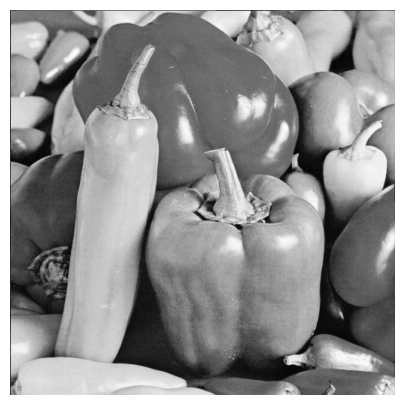

In [50]:
with open('/content/peppers.raw', 'rb') as file:
    peppers = np.fromfile(file, dtype=np.uint8)
peppers = np.reshape(peppers, (512, 512))

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(peppers, cmap='gray')
plt.axis('off')
plt.show()

In [51]:
# Polyphase filter
filter_flag = "ls"
ep1 = 0.0072
ep2 = 0.0075

dims = [512, 600, 750, 512]


In [56]:
import numpy as np

dims = [512, 576, 640, 704, 768, 832, 768, 704, 640, 576, 512]

dims = [512, 600, 512]
print("My Bilinear Inteprolation 12 stages RMSE is")
print(BI_stages(dims, peppers, 16))


My Bilinear Inteprolation 12 stages RMSE is
2.6334366363937476


# Bilinear interpolation code

In [53]:
import numpy as np

def bilinear_transformation(inputImage, row, col, final_size):
    if len(inputImage.shape) == 3:
        h, w, c = inputImage.shape
    elif len(inputImage.shape) == 2:
        h, w = inputImage.shape
        c = 1
    else:
        raise ValueError(f"Invalid inputImage shape: {inputImage.shape}")

    new_rows = np.floor(row).astype(int) - 1
    new_cols = np.floor(col).astype(int) - 1

    fracRows = row - (new_rows+1)
    fracCols = col - (new_cols+1)

    new_rows[new_rows < 0] = 0
    new_rows[new_rows > h - 2] = h - 2
    new_cols[new_cols < 0] = 0
    new_cols[new_cols > w - 2] = w - 2

    TL = inputImage[new_rows, new_cols]
    TR = inputImage[new_rows, new_cols+1]
    BL = inputImage[new_rows+1, new_cols]
    BR = inputImage[new_rows+1, new_cols+1]

    a1 = TL * (1-fracRows) * (1-fracCols)
    a2 = TR * (1-fracRows) * fracCols
    a3 = BL * fracRows * (1-fracCols)
    a4 = BR * fracRows * fracCols

    result = a1 + a2 + a3 + a4

    return result

def BI_stages(dims, input_image, crop_number):
    temp = input_image
    for i in range(1, len(dims)):
        output_dim= dims[i]
        final_size = [output_dim, output_dim]

        change = np.array(final_size) / np.array(temp.shape[:2])
        columns, rows = np.meshgrid(np.arange(1, final_size[1]+1), np.arange(1, final_size[0]+1))

        col = columns / change[1]
        row = rows / change[0]

        resized_image = bilinear_transformation(temp, row, col, final_size)
        temp = resized_image

    input_dim = dims[-1]
    rmse = eval(input_image, resized_image, input_dim, crop_number)  # You should define 'eval' function

    return rmse

def eval(input, restored, input_dim, crop_number):
    inner_dim = input_dim - crop_number
    start_idx = (input_dim - inner_dim) // 2
    end_idx = start_idx + inner_dim

    peppersC = input[start_idx:end_idx, start_idx:end_idx]
    resizedC = restored[start_idx:end_idx, start_idx:end_idx]

    rmse_error = np.linalg.norm(peppersC-resizedC, 'fro') / inner_dim

    return rmse_error



# Polyphase implementation

In [81]:
import numpy as np
from scipy import signal

def resize_image(input_image, input_dim, output_dim, filter_flag, ep1, ep2):
    img = input_image

    # Filter coefficients
    freqs = [0, 1/32-ep1, 1/32+ep2, 1]
    aa = [1, 1, 0, 0]
    ww = [1, 0.7]

    if filter_flag == "ls":
        filterCoeffs = signal.firls(1023, freqs, aa, ww)
    elif filter_flag == "pm":
        filterCoeffs = signal.firpm(319, freqs, aa, ww)

    # Polyphase Filter
    filtCoefp1 = np.concatenate((filterCoeffs, [0]))
    filtCoef_pp = np.reshape(filtCoefp1, (32, -1))

    x_hat = np.round((32 * np.arange(output_dim)) * (input_dim - 1) / (output_dim - 1)).astype(int)

    pp_indx = np.mod(x_hat+31, 32)
    pp_zr = np.ceil(x_hat / 32).astype(int)

    horizontal = np.zeros((input_dim, output_dim))
    for i in range(input_dim):
        yy = np.zeros(output_dim)
        ln = img[i, :]
        for kk in range(32):
            yy += 32 * filtCoef_pp[kk, pp_indx] * ln[np.clip(pp_zr + (16 - kk)-1, 0, input_dim-1)]
        horizontal[i, :] = yy

    resized_image = np.zeros((output_dim, output_dim))
    for i in range(output_dim):
        yy = np.zeros(output_dim)
        ln = horizontal[:, i]
        for kk in range(32):
            yy += 32 * filtCoef_pp[kk, pp_indx] * ln[np.clip(pp_zr + (16 - kk)-1, 0, input_dim-1)]
        resized_image[:, i] = yy

    return resized_image

def res_inter(dims, input_image, ep1, ep2):
    filter_flag = "ls"
    temp = input_image
    for i in range(1, len(dims)):
        input_dim = dims[i-1]
        output_dim= dims[i]
        resized_image = resize_image(temp, input_dim, output_dim, filter_flag, ep1, ep2)
        temp = resized_image
    input_dim = dims[0]
    inner_dim = input_dim-20
    start_idx = (input_dim - inner_dim) // 2
    end_idx = start_idx + inner_dim

    peppersC = input_image[start_idx:end_idx, start_idx:end_idx]
    resizedC = resized_image[start_idx:end_idx, start_idx:end_idx]

    rmse = np.linalg.norm(peppersC-resizedC, 'fro')/inner_dim

    return rmse

filter_flag = "ls"
ep1 = 0.0072
ep2 = 0.0075
dims = [512, 600, 750, 512]

print("My Polyphase RMSE is")
print(res_inter(dims, peppers, ep1, ep2))  # make sure 'peppers' is defined and holds your input image data

a = resize_image(peppers, 512, 600, filter_flag, ep1, ep2)

dims = [512, 576, 640, 704, 768, 832, 768, 704, 640, 576, 512]

print("My Polyphase RMSE for 12 stages is")
print(res_inter(dims, peppers, ep1, ep2))  # make sure 'peppers' is defined and holds your input image data


My Polyphase RMSE is
0.19316363040020101
My Polyphase RMSE for 12 stages is
0.17147855252278807


In [62]:
np.shape(a)

(600, 600)

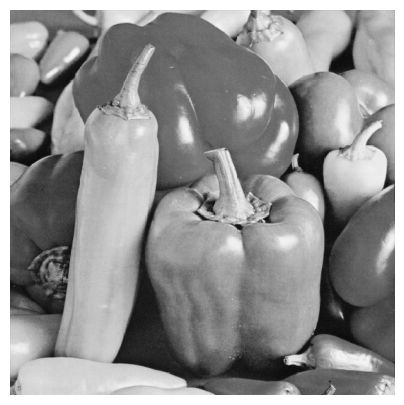

In [60]:
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(a, cmap='gray')
plt.axis('off')
plt.show()

In [63]:
freqs = [0, 1/32-ep1, 1/32+ep2, 1]
aa = [1, 1, 0, 0]
ww = [1, 0.7]

filter_flag = "ls"


filterCoeffs = signal.firls(1023, freqs, aa, ww)
filtCoefp1 = np.concatenate((filterCoeffs, [0]))

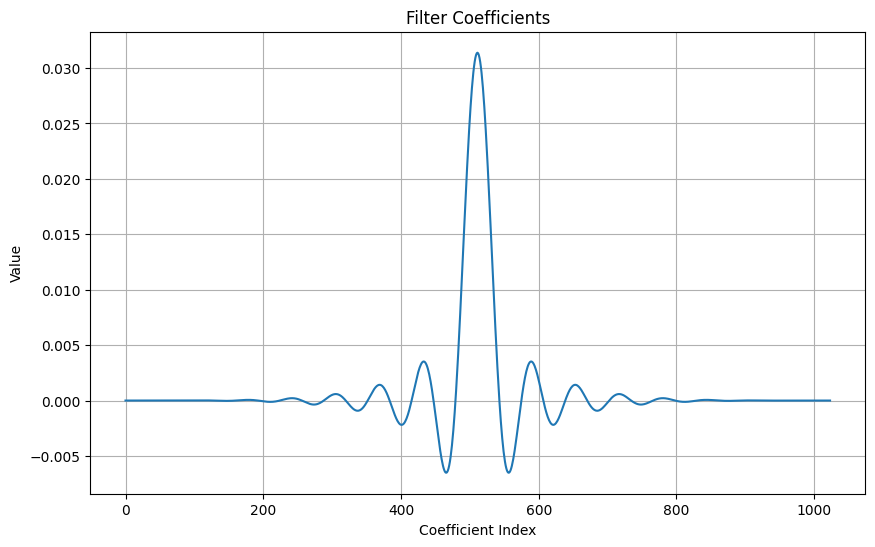

In [64]:
import matplotlib.pyplot as plt

# Assuming 'filterCoeffs' is defined and contains your filter coefficients

plt.figure(figsize=(10,6))
plt.plot(filtCoefp1)
plt.title('Filter Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()


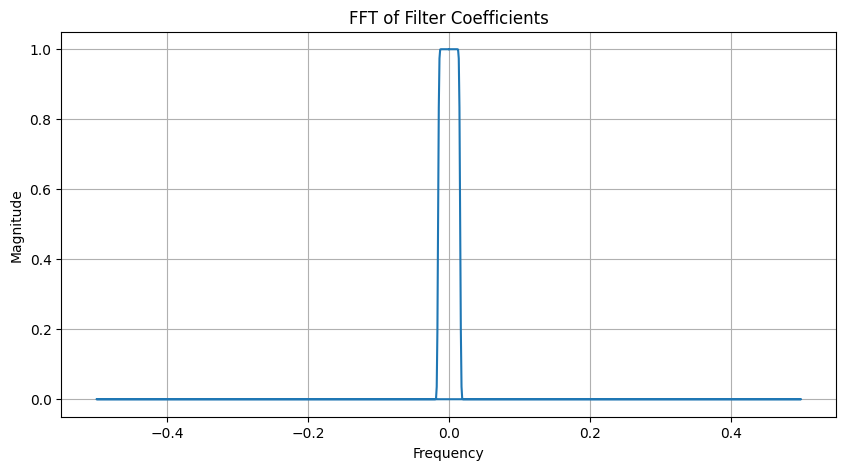

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming filtCoefp1 is your 1D filter coefficients array

fft_result = np.fft.fft(filtCoefp1)
freqs = np.fft.fftfreq(len(filtCoefp1))

plt.figure(figsize=(10,5))
plt.plot(freqs, np.abs(fft_result))
plt.title("FFT of Filter Coefficients")
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()


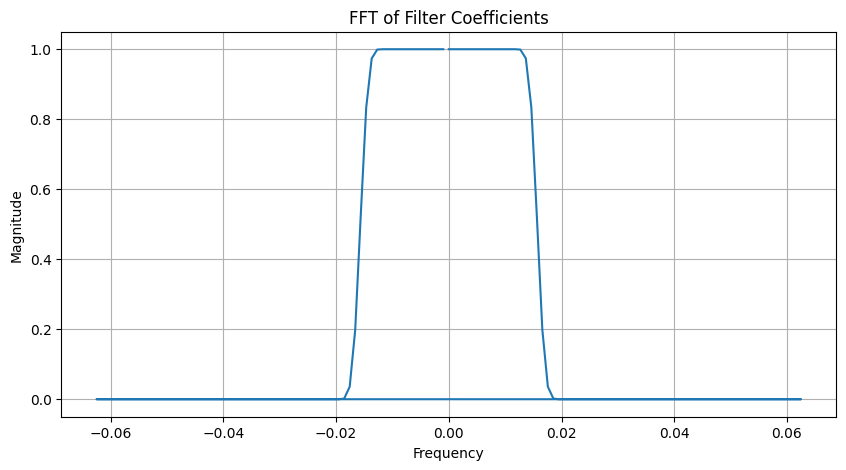

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming filtCoefp1 is your 1D filter coefficients array

fft_result = np.fft.fft(filtCoefp1)
freqs = np.fft.fftfreq(len(filtCoefp1))

# Convert your desired range from [-1/64, 1/64] to [-0.5, 0.5)
start_freq = -1/16
end_freq = 1/16

# Find the indices where your frequencies fall within your desired range
indices = np.where((freqs >= start_freq) & (freqs <= end_freq))

plt.figure(figsize=(10,5))
plt.plot(freqs[indices], np.abs(fft_result)[indices])
plt.title("FFT of Filter Coefficients")
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()


In [22]:
len(filterCoeffs)


1023

# Bilinear+Polyphase



In [82]:
def resize_imageD(input_image, dims, filter_flag, ep1, ep2):

    temp = input_image
    for i in range(1, len(dims)):
        input_dim = dims[i-1]
        output_dim = dims[i]

        im1, im2, im3, im4 = funcD(temp, input_dim, output_dim, filter_flag, ep1, ep2)

        weights1 = (32 * (input_dim - 1) * np.arange(output_dim) / (output_dim - 1)) % 1
        weights2 = 1 - weights1

        restored = (im1 * np.outer(weights2, weights2) +
                    im2 * np.outer(weights1, weights2) +
                    im3 * np.outer(weights2, weights1) +
                    im4 * np.outer(weights1, weights1))

        temp = restored

    input_dim = dims[0]
    crop_number = 16
    inner_dim = input_dim - crop_number
    start_idx = (input_dim - inner_dim) // 2
    end_idx = start_idx + inner_dim

    # Extract inner square
    peppersC = input_image[start_idx:end_idx, start_idx:end_idx]
    restoredC = restored[start_idx:end_idx, start_idx:end_idx]

    # Calculate RMSE error
    rmse_error = np.linalg.norm(peppersC - restoredC, 'fro') / inner_dim

    return restored, rmse_error

import numpy as np
from scipy import signal

def funcD(input_image, input_dim, output_dim, filter_flag, ep1, ep2):
    img = input_image

    freqs = [0, 1/32-ep1, 1/32+ep2, 1]
    aa = [1, 1, 0, 0]
    ww = [1, 0.7]

    if filter_flag == "ls":
        filterCoeffs = signal.firls(1023, freqs, aa, ww)
    elif filter_flag == "pm":
        filterCoeffs = signal.firpm(318, freqs, aa, ww)

    filtCoefp1 = np.concatenate((filterCoeffs, [0]))
    filtCoef_pp = np.reshape(filtCoefp1, (-1, 32))

    x_hat = np.round((32 * np.arange(output_dim)) * (input_dim - 1) / (output_dim - 1)).astype(int)
    x_hat_1 = np.ceil((32 * np.arange(output_dim)) * (input_dim - 1) / (output_dim - 1)).astype(int)
    x_hat_2 = np.floor((32 * np.arange(output_dim)) * (input_dim - 1) / (output_dim - 1)).astype(int)
    y_hat_1 = np.ceil((32 * np.arange(output_dim)) * (input_dim - 1) / (output_dim - 1)).astype(int)
    y_hat_2 = np.floor((32 * np.arange(output_dim)) * (input_dim - 1) / (output_dim - 1)).astype(int)

    pp_indx_x_1 = np.mod((x_hat_1 + 31), 32)
    pp_zr_x_1 = np.ceil(x_hat_1 / 32).astype(int)
    pp_indx_x_2 = np.mod((x_hat_2 + 31), 32)
    pp_zr_x_2 = np.ceil(x_hat_2 / 32).astype(int)
    pp_indx_y_1 = np.mod((y_hat_1 + 31), 32)
    pp_zr_y_1 = np.ceil(y_hat_1 / 32).astype(int)
    pp_indx_y_2 = np.mod((y_hat_2 + 31), 32)
    pp_zr_y_2 = np.ceil(y_hat_2 / 32).astype(int)

    TR = helper_D(input_dim, pp_indx_y_1, pp_zr_y_1, output_dim, pp_indx_x_1, pp_zr_x_1, img, filtCoef_pp)
    BR = helper_D(input_dim, pp_indx_y_2, pp_zr_y_2, output_dim, pp_indx_x_1, pp_zr_x_1, img, filtCoef_pp)
    TL = helper_D(input_dim, pp_indx_y_1, pp_zr_y_1, output_dim, pp_indx_x_2, pp_zr_x_2, img, filtCoef_pp)
    BL = helper_D(input_dim, pp_indx_y_2, pp_zr_y_2, output_dim, pp_indx_x_2, pp_zr_x_2, img, filtCoef_pp)

    return BL, TL, BR, TR

def helper_D(input_dim, pp_indx_y, pp_zr_y, output_dim, pp_indx_x, pp_zr_x, img, filtCoef_pp):
    horizontal = np.zeros((input_dim, output_dim))
    for i in range(input_dim):
        yy = np.zeros(output_dim)
        ln = img[i, :]
        for kk in range(32):
            yy += 32 * filtCoef_pp[kk, pp_indx_x] * ln[np.clip(pp_zr_x + (16 - kk)-1, 0, input_dim-1)]
        horizontal[i, :] = yy

    resized_image = np.zeros((output_dim, output_dim))
    for i in range(output_dim):
        yy = np.zeros(output_dim)
        ln = horizontal[:, i]
        for kk in range(32):
            yy += 32 * filtCoef_pp[kk, pp_indx_y] * ln[np.clip(pp_zr_y + (16 - kk)-1, 0, input_dim-1)]
        resized_image[:, i] = yy

    return resized_image


input_image = peppers  # Make sure 'peppers' is defined and holds your input image data

dims = [512, 600, 750, 512]
print("My Polyphase+Bilinear RMSE is")

restored, rmse_error = resize_imageD(input_image, dims, filter_flag, ep1, ep2)

print(rmse_error)


My Polyphase+Bilinear RMSE is
0.04596860479819206


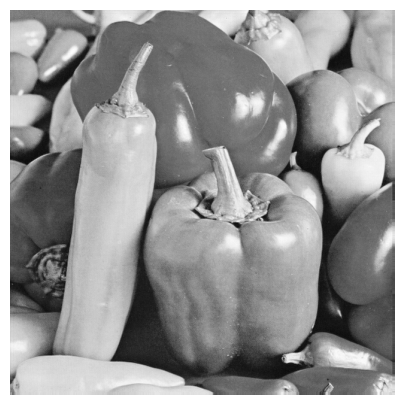

In [71]:
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(restored, cmap='gray')
plt.axis('off')
plt.show()

# Wrapping as PyTorch pooling layer


In [100]:
import torch
import torch.nn as nn

def resize_imageD(input_image, dims, filter_flag, ep1, ep2):

    temp = input_image
    for i in range(1, len(dims)):
        input_dim = dims[i-1]
        output_dim = dims[i]

        im1, im2, im3, im4 = funcD(temp, input_dim, output_dim, filter_flag, ep1, ep2)

        weights1 = (32 * (input_dim - 1) * np.arange(output_dim) / (output_dim - 1)) % 1
        weights2 = 1 - weights1

        restored = (im1 * np.outer(weights2, weights2) +
                    im2 * np.outer(weights1, weights2) +
                    im3 * np.outer(weights2, weights1) +
                    im4 * np.outer(weights1, weights1))

        temp = restored

    input_dim = dims[0]
    crop_number = 16
    inner_dim = input_dim - crop_number
    start_idx = (input_dim - inner_dim) // 2
    end_idx = start_idx + inner_dim

    # Extract inner square
    # peppersC = input_image[start_idx:end_idx, start_idx:end_idx]
    # restoredC = restored[start_idx:end_idx, start_idx:end_idx]

    # Calculate RMSE error
    #rmse_error = np.linalg.norm(peppersC - restoredC, 'fro') / inner_dim

    return restored

class ResizeImageDLayer(nn.Module):
    def __init__(self, dims, filter_flag, ep1, ep2):
        super(ResizeImageDLayer, self).__init__()
        self.dims = dims
        self.filter_flag = filter_flag
        self.ep1 = ep1
        self.ep2 = ep2

    def forward(self, input):
        batch_size, num_channels, _, _ = input.shape

        # Create a list to hold the output feature maps
        output_feature_maps = []

        # Loop over each image in the batch
        for i in range(batch_size):
            # Loop over each channel in the image
            output_channels = []
            for j in range(num_channels):
                # Select the 2D feature map for this image and this channel
                input_feature_map = input[i, j].detach().cpu().numpy()

                # Apply the resize_imageD function
                output_feature_map_np = resize_imageD(input_feature_map, self.dims, self.filter_flag, self.ep1, self.ep2)

                # Convert the output feature map back to a PyTorch tensor and add it to the list
                output_feature_map = torch.from_numpy(output_feature_map_np).float().to(input.device)
                output_channels.append(output_feature_map)

            # Stack all channels for a single image together along the 0th dimension
            output_image = torch.stack(output_channels)
            output_feature_maps.append(output_image)

        # Stack all images in the batch together along the 0th dimension to create the final output tensor
        output = torch.stack(output_feature_maps)

        return output



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
import torchvision
import torchvision.transforms as transforms

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        # Polyphase filter
        filter_flag = "ls"
        ep1 = 0.0072
        ep2 = 0.0075

        self.pool = ResizeImageDLayer([28, 14], "ls", 0.0072, 0.0075)  # Set the parameters accordingly
        self.fc = nn.Linear(14*14*16, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        print(np.shape(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Load the Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
full_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Create a subset of 500 images
indices = torch.randperm(len(full_trainset))[:500]
trainset = Subset(full_trainset, indices)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Create the network, define the criterion and optimizer
net = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the network
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

print(running_loss)

torch.Size([64, 16, 28, 28])
torch.Size([64, 16, 28, 28])
torch.Size([64, 16, 28, 28])


In [86]:
full_trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

# Below is PyTorch implementation

In [ ]:
# Create 1D tensor

import torch

a = torch.tensor([7,4,3,2,6])

print(a.dtype)
print(a.type())

torch.int64
torch.LongTensor


In [ ]:
a = torch.FloatTensor([0,1,2,3,4])

print(a.dtype)
print(a.type())

torch.float32
torch.FloatTensor


In [ ]:
a = a.type(torch.LongTensor)

print(a.dtype)
print(a.type())

torch.int64
torch.LongTensor


In [ ]:
print("size is", a.size())
print("dim is", a.ndimension())

size is torch.Size([5])
dims are 1


In [ ]:
a_col = a.view(5,1)

print("size is", a_col.size())
print("dim is", a_col.ndimension())

RuntimeError: ignored

In [ ]:
a_col = a.view(-1,1)

print("size is", a_col.size())
print("dim is", a_col.ndimension())

size is torch.Size([5, 1])
dim is 2


Any element of the tensor is also tensor. Now indexing and slicing:

In [ ]:
# same as lists basically